In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 2468
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Load Data

In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
parent_path = Path('./data/biological/EB095/')
stim_path = parent_path / "EB095_stim/"
run_path = parent_path / "EB095_run/"
save_path = Path('./save/trained_models/')

area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'spks_stim.npy')                # (106, 94096)
speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load(stim_path /'stim_ID.npy')
stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

Exploratory analysis: Running vs Activity

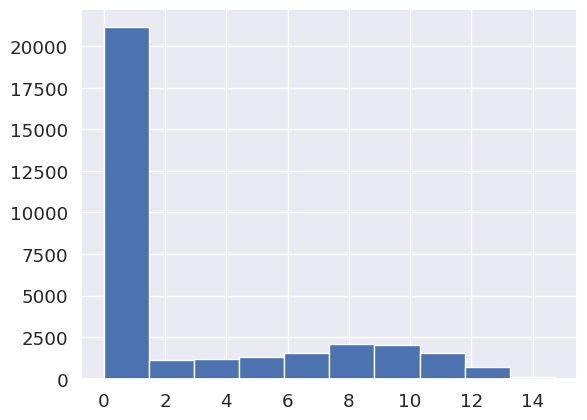

In [3]:
# (106, 56322)
plt.hist(speed_run) # (56302)
plt.show()

Naive model fitting:
Ignore running / stationary, fit model to both data.

### Preprocessing

#### Convolve spikes

In [4]:
spks_stim_rates = rbf_rate_convolution_2d(spks_stim.T, sigma=0.1) # [93996, 106]
n_output_neurons, n_bins = spks_stim.shape
n_input_neurons = dff_stim.shape[0]
spks_stim_rates = torch.hstack([torch.zeros((n_output_neurons, 50)), spks_stim_rates, torch.zeros((n_output_neurons, 50))])

assert np.array(spks_stim_rates.shape).all() == np.array(spks_stim.shape).all()

spks_stim_rates = spks_stim_rates.T

##### Plot sample

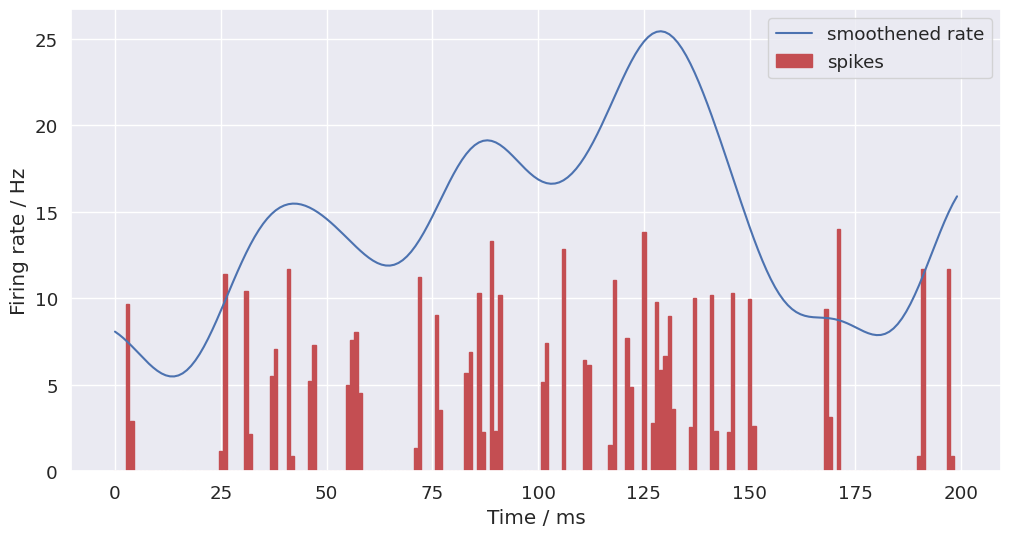

In [5]:
# visualise a sample of ephys smooth rates
_range = 200
_random_start = np.random.randint(0, n_bins-_range)
_random_neuron_idx = np.random.randint(0, n_output_neurons)

plt.figure(figsize=(12,6))
plt.plot(spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx], label='smoothened rate')
plt.bar(np.arange(200), height = spks_stim[_random_neuron_idx, _random_start:_random_start+_range] * spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

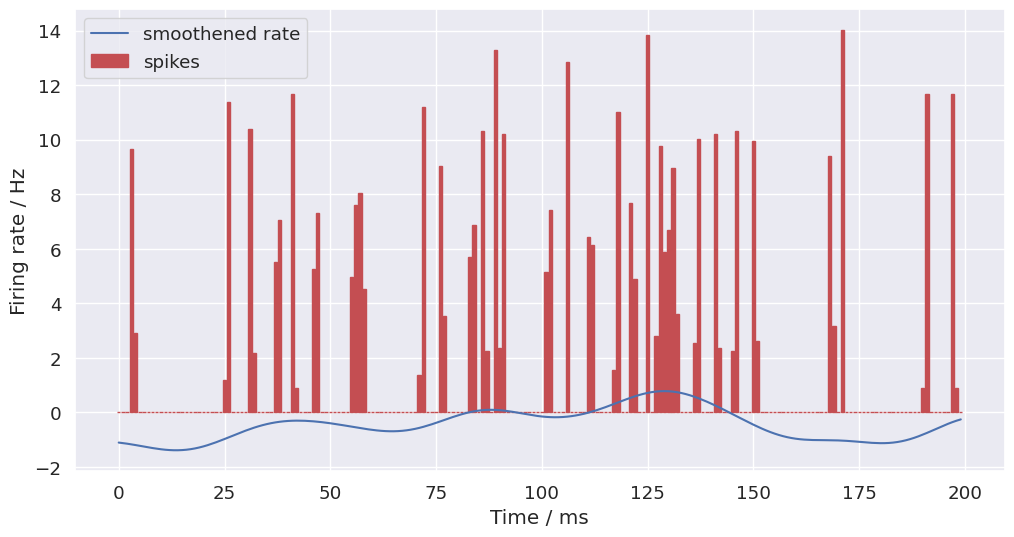

In [6]:
from utils import normalise_data
spks_stim_rates_normalised = normalise_data(spks_stim_rates, mean=spks_stim_rates.mean(0), std=spks_stim_rates.std(0))

plt.figure(figsize=(12,6))
plt.plot(spks_stim_rates_normalised[_random_start:_random_start+_range, _random_neuron_idx], label='smoothened rate')
plt.bar(np.arange(200), height = spks_stim[_random_neuron_idx, _random_start:_random_start+_range] * spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

##### Average firing rates of each neuron

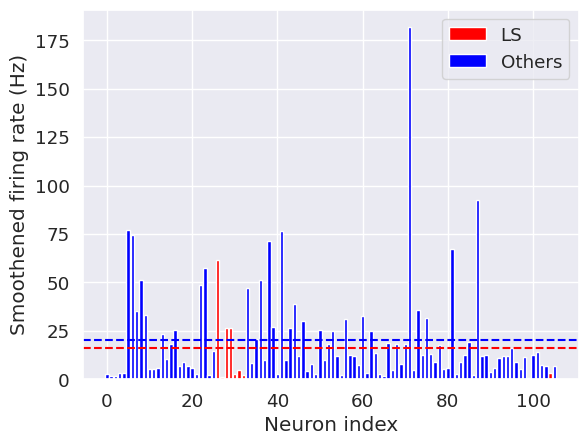

LS neuron firing rate: 16.095746994018555 Hz
non-LS neuron firing rate: 20.01192283630371 Hz


In [7]:
mask1 = area_ID_ephys == 'LS'
mask2 = area_ID_ephys != 'LS'

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

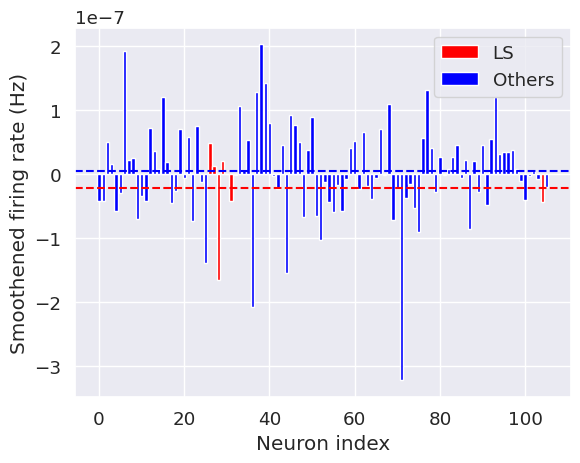

LS neuron firing rate: -2.1027418029007094e-08 Hz
non-LS neuron firing rate: 5.93456217501398e-09 Hz


In [8]:
plt.bar(np.arange(spks_stim_rates_normalised.shape[1])[mask1], spks_stim_rates_normalised.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates_normalised.shape[1])[mask2], spks_stim_rates_normalised.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates_normalised.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates_normalised.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates_normalised.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates_normalised.mean(0)[mask2].mean()} Hz')

#### Extract stim instances

In [9]:
tsteps = 15
cutoff_size = 1

dff_stim = dff_stim.T

assert dff_stim.shape[0] == spks_stim_rates_normalised.shape[0]

n_vecs = int(spks_stim_rates_normalised.shape[0] / tsteps)
input_dim = dff_stim.shape[1]
output_dim = spks_stim_rates_normalised.shape[1]
n_vecs = int(spks_stim_rates_normalised.shape[0]/tsteps)
n_stims = len(stim_ID)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(spks_stim_rates_normalised)
img_array = torch.as_tensor(dff_stim)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])

# edge case: last stim happens to be in the last bin.
# stim_vecs_idx = stim_vecs_idx[:-1]

non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

# non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [10]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

## Training

### LS Neurons

In [11]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))


forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [12]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 8192
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=True)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)
del train_dataset, test_dataset, valid_dataset

#### Bayes Opt

In [13]:
_run_bo = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run_bo:
    run_bayes_opt(pbounds = {'d_model':(100, 1000), 'num_heads':(1, 20), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-LS-param_counts.npy', np.array(LS_param_counts))

#### Train Transformer

In [14]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |

d_model = 128
num_heads = 8
hidden_dim = 512
n_layers = 3


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=False,
                bin_output=False,
                softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                    mode='min', 
                                                    factor=0.5, 
                                                    patience=25, 
                                                    threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader_LS,
            test_loader=test_dataloader_LS,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=False,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

 44%|████▍     | 221/500 [08:23<10:35,  2.28s/it]


#### Save Transformer

In [16]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs}
        }

torch.save(return_dict['best_eval_params'], save_path / 'EB095-stim-LS-transformer-normalised-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth')
with open(save_path / 'EB095-stim-LS-transformer-normalised-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-normalised-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}')

Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-normalised-param-metadata-128-8-512-3


In [17]:
# with open(save_path / 'EB095-stim-LS-transformer-param-metadata.pkl', 'rb') as f:
#     data = pickle.load(f)
best_eval_params = torch.load(save_path / 'EB095-stim-LS-transformer-normalised-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth')
DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(0.6975)
Transformer prediction for forward stim MSE loss:  tensor(0.5435)
Transformer prediction for backward stim MSE loss:  tensor(0.8230)
Transformer prediction for random stim MSE loss:  tensor(0.7506)
Transformer prediction for non-stim stim MSE loss:  tensor(0.6848)


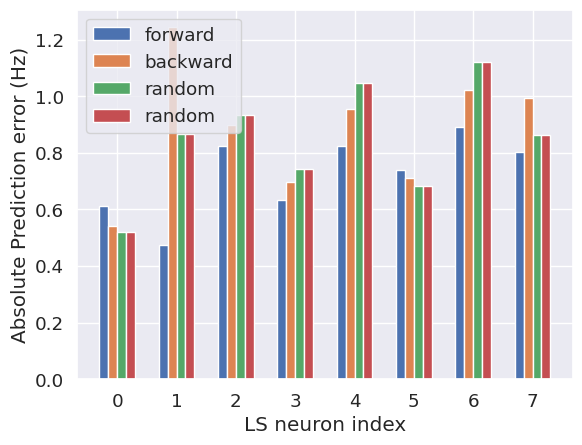

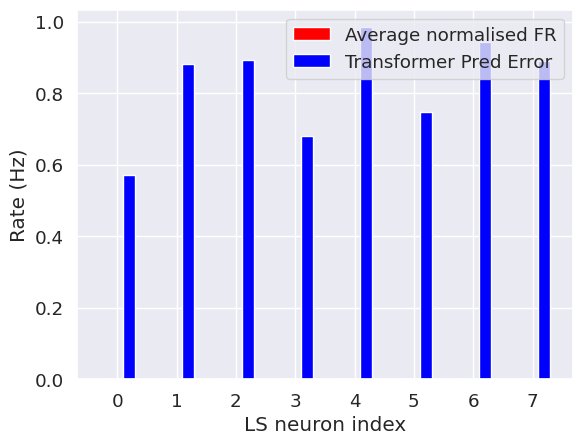

In [18]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.225, torch.sqrt(LS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.075, torch.sqrt(LS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.075, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.225, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')

plt.xlabel('LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, spks_stim_rates_normalised.mean(0)[mask1], color='red', width=0.2, label='Average normalised FR')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_LS_np
    plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

In [34]:
torch.corrcoef(torch.vstack((spks_stim_rates[:,LS_neuron_idx].mean(0), torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]))))[0][1]

tensor(-0.7928)

#### Train GLM

In [21]:
from loguru import logger

# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=0, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

2024-02-27 13:27:58.254 | INFO     | __main__:<module>:21 - Loss for LS neuron No 0: 0.3621014404296875 (Hz^2).
2024-02-27 13:27:58.258 | INFO     | __main__:<module>:22 - Forward: 0.4155584716796875, Backward: 0.36425346903281636, Random: 0.266979506521514. Endogenous: 0.3813714599609375
2024-02-27 13:28:13.546 | INFO     | __main__:<module>:21 - Loss for LS neuron No 1: 0.711625732421875 (Hz^2).
2024-02-27 13:28:13.548 | INFO     | __main__:<module>:22 - Forward: 0.16554779052734375, Backward: 1.5204750287650834, Random: 0.6840281631007339. Endogenous: 0.5898565673828124
2024-02-27 13:28:29.994 | INFO     | __main__:<module>:21 - Loss for LS neuron No 2: 0.81893896484375 (Hz^2).
2024-02-27 13:28:29.998 | INFO     | __main__:<module>:22 - Forward: 0.6797948455810547, Backward: 0.8072089771232983, Random: 0.8855839738942156. Endogenous: 0.8614453887939453
2024-02-27 13:28:47.221 | INFO     | __main__:<module>:21 - Loss for LS neuron No 3: 0.52394677734375 (Hz^2).
2024-02-27 13:28:47.22

2024-02-27 13:30:47.347 | INFO     | __main__:<module>:1 - Predicting mean for each of the 8 LS neurons: [0.989511   0.71925086 0.9591648  1.0551151  1.2310896  1.0877696
 1.0977191  0.8359906 ]


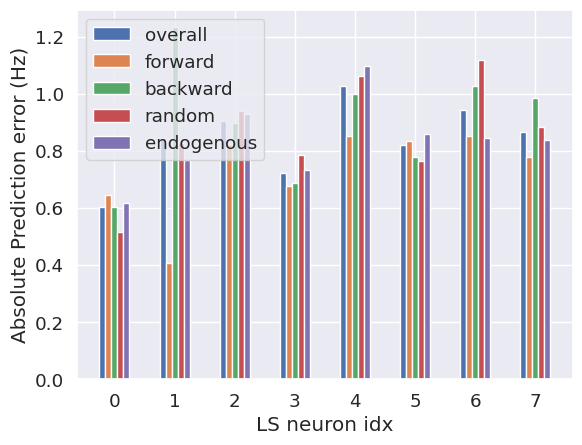

In [22]:
logger.info(f'Predicting mean for each of the 8 LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

plt.figure()
plt.bar(np.arange(8)-0.2, np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
plt.bar(np.arange(8)-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
plt.bar(np.arange(8), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
plt.bar(np.arange(8)+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
plt.bar(np.arange(8)+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.xlabel('LS neuron idx')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

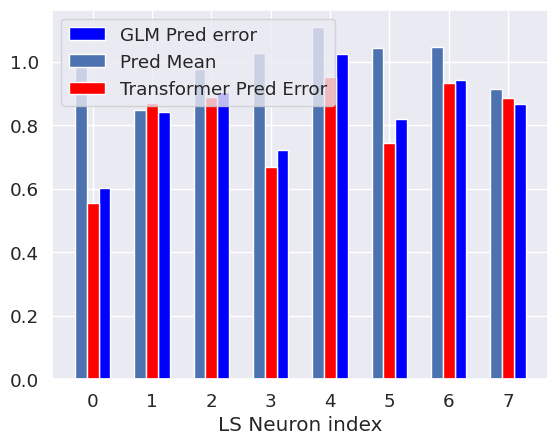

In [27]:
plt.figure()
# plt.bar(np.arange(8) - 0.2, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(8) + 0.2, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.2, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
plt.bar(np.arange(len(LS_neuron_idx)), torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='red', width=0.2, label='Transformer Pred Error')
plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

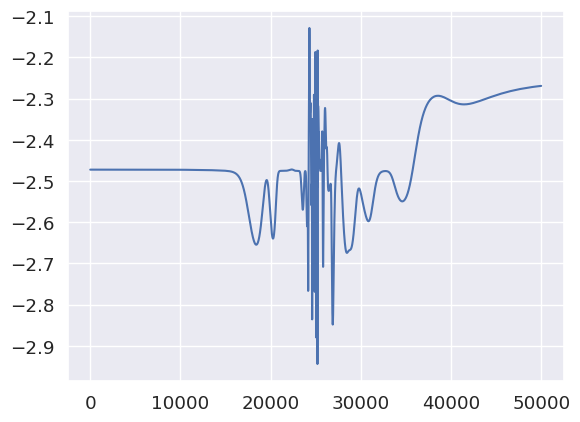

In [61]:
x = torch.linspace(-500,500,50000)[:, None]
l1 = nn.Linear(1, 128)
l2 = nn.Linear(128, 128)
l3 = nn.Linear(128, 1)
a = nn.Sigmoid()
with torch.no_grad():
    y = 1/l3(a(l2(256*a(l1(x)))**2))
plt.plot(y)

## RNN

In [ ]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import RecurrentDNN
from train import train_rnn
from utils import count_parameters

LS_rnn_param_counts = []

import gc
def black_box_function(hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
        
    RNN = RecurrentDNN(input_dim=input_dim,
                       hidden_dim=hidden_dim,
                       n_linear_layers=n_layers,
                       n_rec_layers=1,
                       output_dim=output_dim).to(device)
    
    optimiser = torch.optim.Adam(RNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)

    return_dict = train_rnn(
        model=RNN, train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, optimiser = optimiser, criterion = criterion, num_epochs = 1000, verbose=True, force_stop=False, scheduler=scheduler)

    LS_rnn_param_counts.append([min(return_dict['eval_losses']), count_parameters(RNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del RNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'hidden_dim':(10, 1000), 'n_layers':(0, 5)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-LS-rnn-param_counts.npy', np.array(LS_rnn_param_counts))

### Non-LS neurons

In [23]:
Y_train_nLS = Y_train[train_idx,:,:][..., nLS_neuron_idx]
Y_test_nLS = Y_test[..., nLS_neuron_idx]
Y_valid_nLS = Y_train[valid_idx,:,:][..., nLS_neuron_idx]

output_dim = len(nLS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_nLS)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

#### Bayes Opt

In [55]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer
import gc

nLS_param_counts = []
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)
    
    nLS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN)])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

np.save(f'./data/trained_models/EB095-stim-LS-param_counts.npy', np.array(nLS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


| 1         | -172.8    | 475.3     | 748.3     | 1.0       | 6.744     |


 30%|███       | 75/250 [00:20<00:48,  3.57it/s]


KeyboardInterrupt: 

#### Train Transformer

In [24]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 6         | -149.4    | 820.7     | 971.4     | 2.254     | 14.15     |

d_model = 820
num_heads = 14
hidden_dim = 971
n_layers = 2

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model %2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=d_model,
                    num_heads=num_heads,
                    hidden_dim=hidden_dim,
                    output_dim=output_dim,
                    n_layers=n_layers,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

In [50]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                    mode='min', 
                                                    factor=0.5, 
                                                    patience=25, 
                                                    threshold=0.01)
num_epochs = 800

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


backward_loss,█▅▃▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▂▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁
eval_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forward_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▂▂▁▁▁▂▁▁
learning_rate,████████▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nonstim_loss,█▅▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
random_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
backward_loss,130.44614
eval_loss,140.77507
forward_loss,118.84829
learning_rate,0.0


100%|██████████| 800/800 [22:01<00:00,  1.65s/it]


#### Save Transformer

In [52]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs},
        'train_data': return_dict}


torch.save(return_dict['best_eval_params'], save_path / 'EB095-stim-nLS-transformer-param.pth')
with open(save_path / 'EB095-stim-nLS-transformer-param-metadata.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/')

Saved model parameters and training stats to ./save/trained_models/


In [25]:
with open(save_path / 'EB095-stim-LS-transformer-param-metadata.pkl', 'rb') as f:
    data = pickle.load(f)
DNN_nLS.load_state_dict(torch.load(save_path / 'EB095-stim-nLS-transformer-param.pth'))

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,nLS_neuron_idx])
    print('Overall Transformer Loss:', nLS_test_pred_loss.sum()/np.prod(nLS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(170.7240)
Transformer prediction for forward stim MSE loss:  tensor(153.3932)
Transformer prediction for backward stim MSE loss:  tensor(160.9188)
Transformer prediction for random stim MSE loss:  tensor(172.7477)
Transformer prediction for non-stim stim MSE loss:  tensor(183.3393)


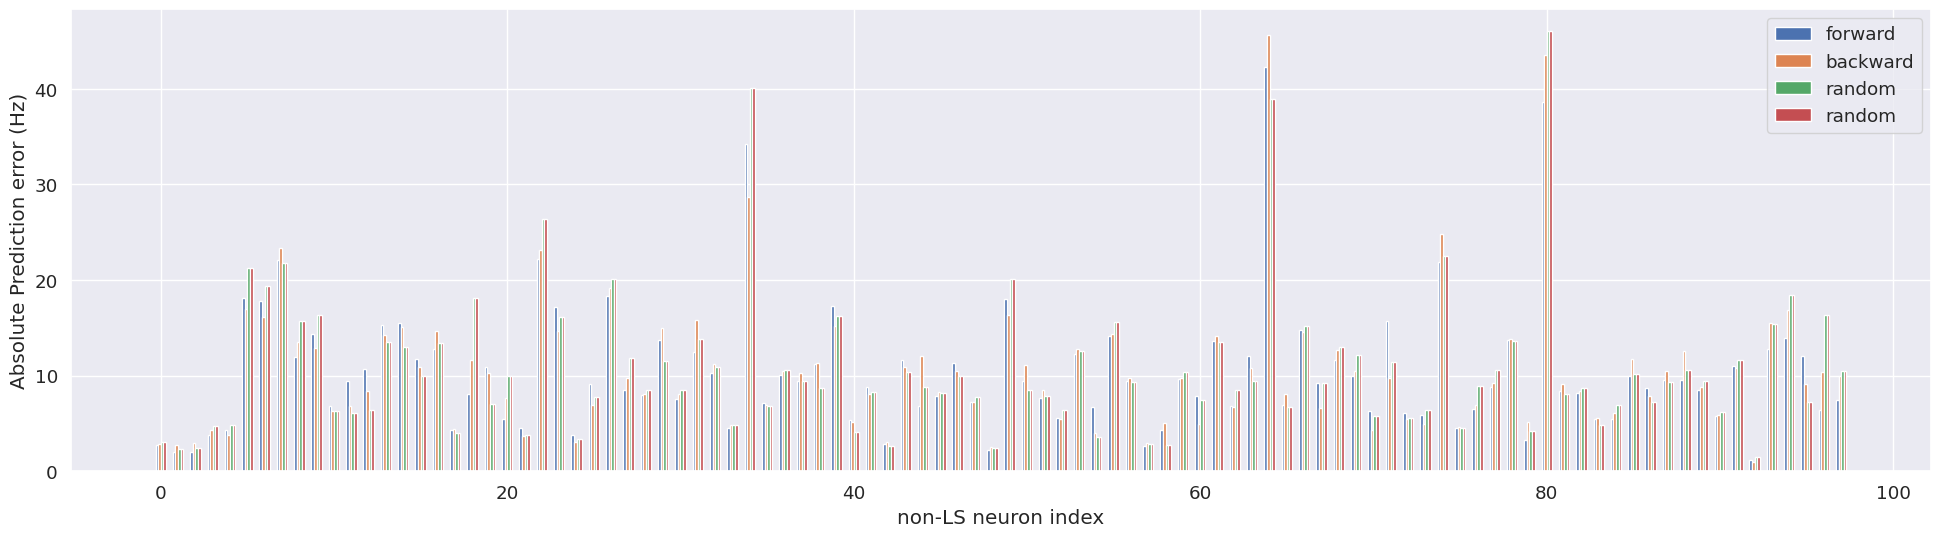

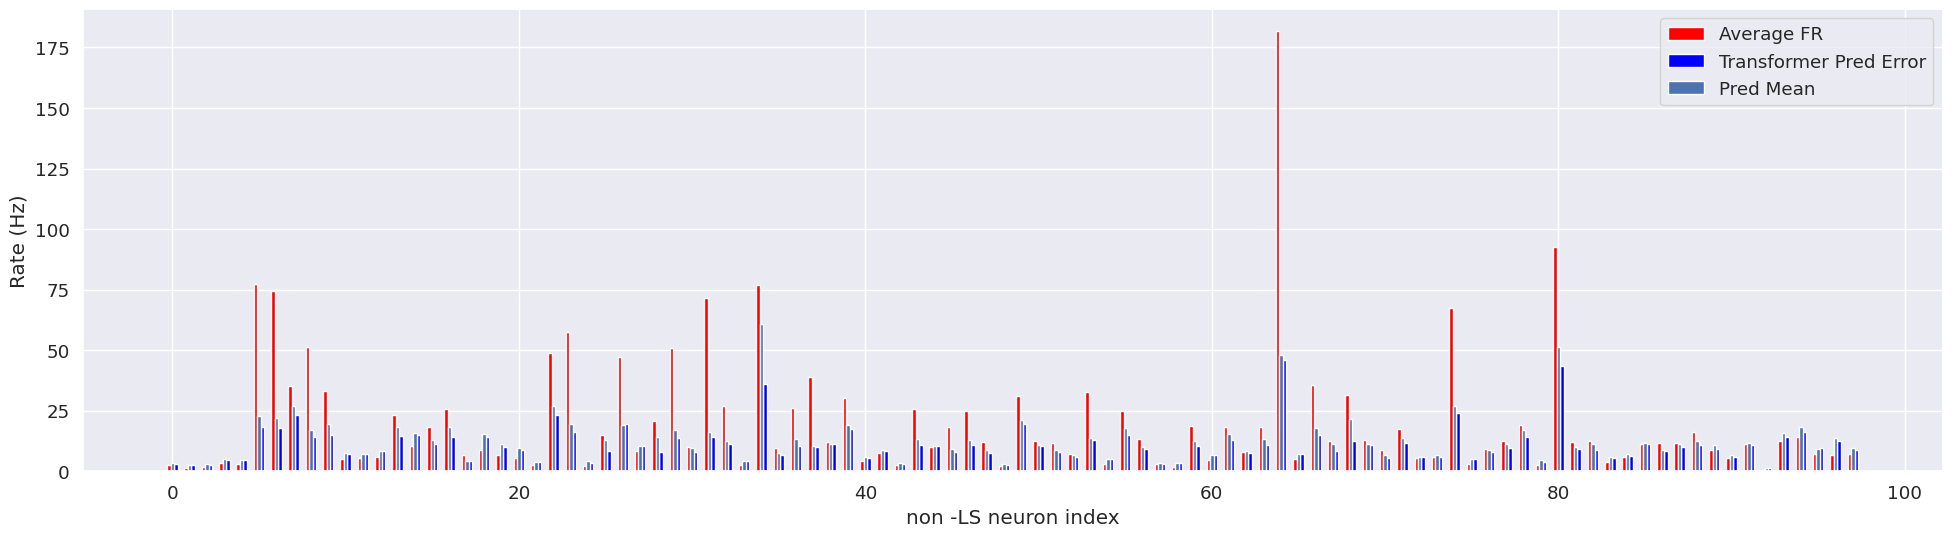

In [28]:
plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.225, torch.sqrt(nLS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(output_dim) - 0.075, torch.sqrt(nLS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(output_dim) + 0.075, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(output_dim) + 0.225, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.xlabel('non-LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.2, spks_stim_rates.mean(0)[mask2], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(output_dim) + 0.2, torch.sqrt(nLS_test_pred_loss.sum(0)[0]/nLS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_nLS_np
    plt.bar(np.arange(output_dim), np.sqrt(np.power(Y_test_nLS_np - Y_test_nLS_np.mean(0), 2).sum(0) / Y_test_nLS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('non -LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

#### Train GLM

In [27]:
# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros_like(Y_test_nLS_np)
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses[:,i] += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)

  0%|          | 0/98 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Evaluation

In [30]:
def levenshtein_distance(arr1, arr2):
    m = len(arr1)
    n = len(arr2)

    # Create a matrix to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill in the rest of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if arr1[i - 1] == arr2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],        # Deletion
                                   dp[i][j - 1],        # Insertion
                                   dp[i - 1][j - 1])    # Substitution

    # The bottom-right cell of the matrix contains the Levenshtein distance
    return dp[m][n]

levs_dist = [levenshtein_distance(arr, [1,2,3,4,5,6]) for arr in stim_ID_resolved]

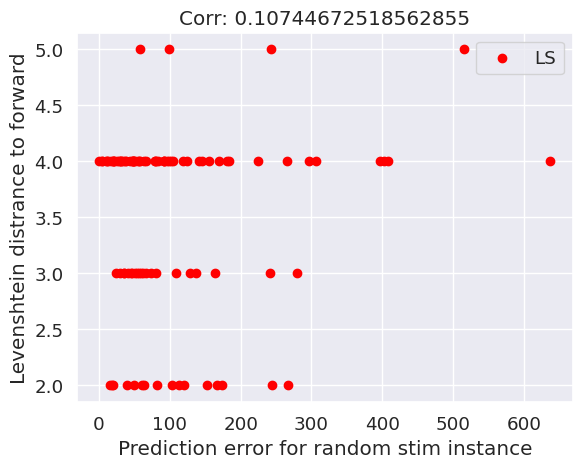

In [44]:
plt.figure()
plt.scatter(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='red', label='LS')

plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()
plt.show()

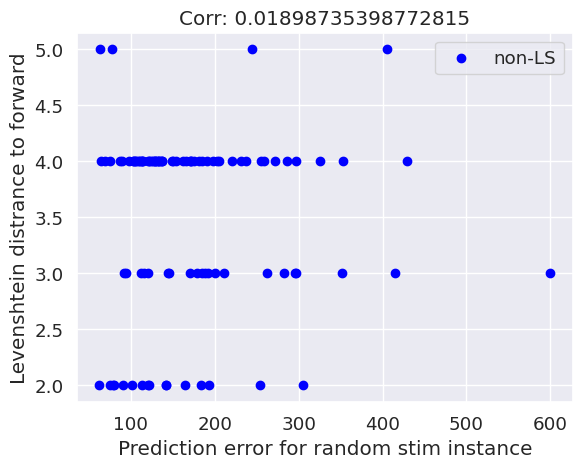

In [42]:
plt.figure()
plt.scatter(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='blue', label='non-LS')
plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()

plt.show()


In [46]:
LS_test_pred_loss.mean.shape

torch.Size([500, 1, 8])

<BarContainer object of 98 artists>

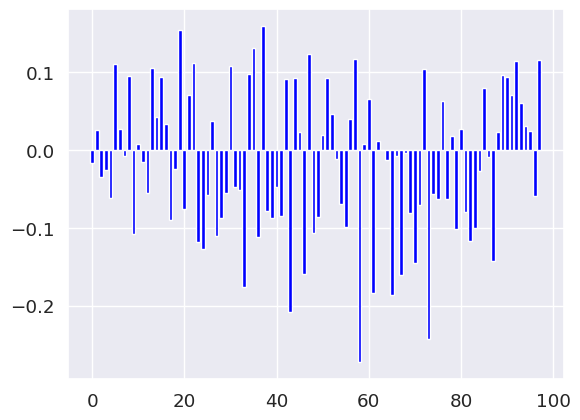

In [53]:
nLS_corrs = [np.corrcoef(nLS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(98)]
    
plt.bar(np.arange(98), nLS_corrs, color='blue')

<BarContainer object of 8 artists>

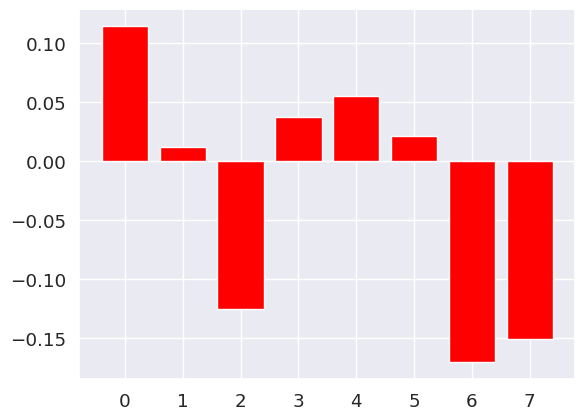

In [54]:
LS_corrs = [np.corrcoef(LS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(8) ]
    
plt.bar(np.arange(8), LS_corrs, color='red')